Quick analysis

In [2]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl



from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
from pygama.dsp.WaveformBrowser import WaveformBrowser

#do this to use cage_utils functions
import sys
sys.path.insert(1, '../analysis/')
import cage_utils
plt.style.use('../analysis/joule_dissertation.mplstyle')

In [3]:
run = 64 #44 #70 #64

dsp_id = '02'

user = True
hit = True
cal = True
lowE= False
cut = True

if cal==True:
    etype = 'trapEftp_cal'
    # dsp list for calibrated data
    dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']
    
else:
    etype = 'trapEftp'
    # dsp list for uncalibrated data
    dsp_list = ['energy', 'trapEftp', 'trapEmax', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']


df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)

Radius: 7.5; Angle: 90; Rotary: 0.0
user: True; cal: True; hit: True
Using hit files
loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc869_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc870_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc871_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc872_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc873_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc874_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc875_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc876_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc877_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc878_hit.lh5


In [4]:
# get raw files for wfs

raw_lh5_dir = dg.lh5_dir
raw_list = raw_lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']

print(raw_list)



867    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
868    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
869    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
870    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
871    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
872    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
873    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
874    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
875    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
876    /global/cfs/cdirs/m2676/data/cage/LH5/raw/cage...
dtype: object


Apply data-cleaning cuts if relevant

In [5]:
if cut == True:
    print(f'Making cut')
    df_cut = cage_utils.apply_DC_Cuts(run, df_raw)
else:
    df_cut = df_raw

Making cut
No options specified for cut selection! Using default: {'bl_sig_cut_raw', 'wf_max_cut', 'bl_mean_cut_raw', 'ftp_max_cut_raw', 'bl_slope_cut_raw'}
total counts before cuts: 1123599
applying cut: bl_sig_cut_raw
Percentage surviving bl_sig_cut_raw cut: 95.00
applying cut: wf_max_cut
Percentage surviving wf_max_cut cut: 98.21
applying cut: bl_mean_cut_raw
Percentage surviving bl_mean_cut_raw cut: 95.00
applying cut: ftp_max_cut_raw
Percentage surviving ftp_max_cut_raw cut: 95.00
applying cut: bl_slope_cut_raw
Percentage surviving bl_slope_cut_raw cut: 95.00
Percentage surviving cuts: 85.40


Make baseline cut if didn't apply other cuts

In [ ]:
# use baseline cut

if run <79:
    bl_cut_lo, bl_cut_hi = 9150,9320
if run>79 and run <117:
    bl_cut_lo, bl_cut_hi = 8500, 10000
if run>=117:
    bl_cut_lo, bl_cut_hi = 9700, 9760

df_cut = df_cut.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()

In [ ]:
# baseline cut
bl = df_cut['bl']
bl_cut = (bl > bl_cut_lo) & (bl < bl_cut_hi)

# print(cut)
print(bl_cut.value_counts())

In [6]:
##### energy cut 
energy = df_cut[etype]

if cal == True:
    # energy = df['trapEmax_cal']
    energy_cut = (energy > 1450) & (energy < 1470) # 1460 peak
    # energy_cut = (energy > 60) & (energy < 65) # 60 keV peak
    
else:
    # energy = df_hit['trapEmax']
    energy_cut = (energy > 2805) & (energy < 2835) # 1460 peak, uncalibratedm trapEmax
    # energy_cut = (energy > 2000000) & (energy < 2500000) #where alphas seem to be in run 117, raw energy parameter
    # energy_cut = (energy > 200) & (energy < 1000) #where low e weirdness is in DCR, in trapEftp
    
# print(type(energy))
# print(energy_cut)
print(energy_cut.value_counts())

False    946022
True      13530
Name: trapEftp_cal, dtype: int64


In [ ]:
energy_raw = df_cut['energy']
energy_cut_raw = (energy_raw > 10200) & (energy_raw < 10600)

In [7]:
# cut = bl_cut & energy_cut
cut = energy_cut

In [8]:
# for debugging

# print(cut)
print(cut.value_counts())

False    946022
True      13530
Name: trapEftp_cal, dtype: int64




DCR Plots



In [26]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
print(dsp_config_file)
browser = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pzDCR', 'dcr_trap'], # names of waveforms from dsp config file
                          selection   = energy_cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected', 'DCR trap.' ],
#                           legend_opts={'loc':"upper left"},
                          lines=['dcr'], # add hlines and vlines
                          x_lim=(38000, 80000) # x axis range
                         )

/global/homes/g/gothman/projecta/joule_CAGE/processing/metadata/dsp/dsp_02.json
Processing parameters: ['bl, bl_sig', 'wf_blsub', 'wf_pzDCR', 'dcr_trap', 'dcr_trap_max', 'dcr']
Required input parameters: ['waveform']
Copied output parameters: []
Processed output parameters: ['wf_blsub', 'wf_pzDCR', 'dcr_trap', 'dcr']
Database lookup: using default value of 212.5*us for db.pz2.tau1
Database lookup: using default value of 4.33*us for db.pz2.tau2
Database lookup: using default value of 0.045 for db.pz2.frac


In [ ]:
plt.rcParams['figure.figsize'] = [14, 10]


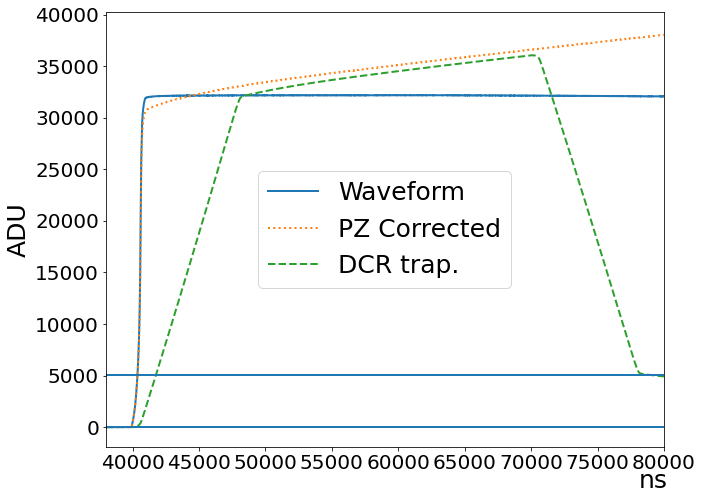

In [28]:
# fig, ax = plt.subplots()
browser.draw_next()
# browser.draw_next()
# plt.ylim(0, 100)
# plt.plot(4090)
# plt.setp(ax.get_xticklabels(), fontsize=18)
plt.ylabel('ADU')
plt.axhline(0.)

Energy Plots

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser2 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pz', 'wf_trap'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected',  'trapEftp = {trapEftp:0.2f}'],
#                           legend_opts={'loc':"upper left"},
                          lines=['trapEftp'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

In [ ]:
browser2.draw_next()
# plt.ylim(4000, 4500)

TP_0

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser3 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pz', 'wf_atrap'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected',  't0 = {tp_0:0.2f}'],
#                           legend_opts={'loc':"upper left"},
                          lines=['tp_0'], # add hlines and vlines
                          x_lim=(0, 50000) # x axis range
                         )

In [ ]:
browser3.draw_next()
plt.ylim(-10, 200) 
plt.xlim(38000, 45000)

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser_tri = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pz', 'wf_triangle'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected',  'triE= {triE:0.2f}'],
#                           legend_opts={'loc':"upper left"},
                          lines=['triE'], # add hlines and vlines
                          x_lim=(0, 50000) # x axis range
                         )

In [ ]:
browser_tri.draw_next()
# plt.ylim(-10, 100) 
plt.xlim(38000, 45000)

WF_psd

LF PD

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser4 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_psd', 'wf_psd'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']}],
                          legend=['lf_max = {lf_max:0.2f}', 'wf_psd'], #{tp_0:0.2f}
#                           legend_opts={'loc':"upper left"},
                          lines=['lf_max'], # add hlines and vlines
                          x_unit = 'khz',
                          x_lim=(0, 200), # x axis range,
                          verbosity=2
                         )

In [ ]:
browser4.draw_next()
# plt.ylim(0, 2000)

HF PSD

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser5 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_psd', 'wf_psd'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']}],
                          legend=['hf_max = {hf_max:0.2f}', 'wf_psd'], #{tp_0:0.2f}
#                           legend_opts={'loc':"upper left"},
                          lines=['hf_max'], # add hlines and vlines
                          x_unit = 'mhz',
                          x_lim=(0, 50), # x axis range,
                          verbosity=2
                         )

In [ ]:
browser5.draw_next()
# plt.ylim(0, 2000)

Baseline Slope

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser6 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub', 'wf_pzDCR', 'bl_trap'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']},{'linestyle':[':']},{'ls':['--']}],
                          legend=['Waveform', 'PZ Corrected', "bl_slope: {bl_slope:0.2f}"],
#                           legend_opts={'loc':"upper left"},
                          lines=['bl_slope'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

In [ ]:
browser6.draw_next()
# plt.ylim(0, 20000)

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser7 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['log_tail'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']}],
                          legend=['log tail'],
#                           legend_opts={'loc':"upper left"},
                          # lines=['log_tail'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

In [ ]:
browser7.draw_next()
plt.xlim(0, 40000)

In [ ]:
dsp_config_file = os.path.expandvars(f'$CAGE_SW/processing/metadata/dsp/dsp_{dsp_id}.json')
browser8 = WaveformBrowser(raw_list, 'ORSIS3302DecoderForEnergy/raw', dsp_config_file, # Need to include a dsp config file!
                          database={"pz_const":'396.9*us'}, # TODO: use metadata instead of manually defining...
                          waveforms=['wf_blsub'], # names of waveforms from dsp config file
                          selection   = cut,           # Apply cut
                          wf_styles=[{'linestyle':['-']}],
                          legend=['log tail'],
#                           legend_opts={'loc':"upper left"},
                          # lines=['log_tail_lin_fit'], # add hlines and vlines
                          x_lim=(0, 80000) # x axis range
                         )

In [ ]:
browser8.draw_next()
plt.xlim(0, 40000)